# Principal Component Analysis for Galaxy Images

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 10 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of statistical machine learning techniques, we've established frameworks for supervised learning through regression and classification. We now turn our attention to unsupervised learning, beginning with one of the most fundamental and widely-used techniques: Principal Component Analysis (PCA). In the expanding universe of astronomical data, we routinely encounter high-dimensional datasets that challenge our ability to extract meaningful patterns. Modern sky surveys produce images containing thousands or even millions of pixels, spectroscopic observations span thousands of wavelength channels, and time-domain surveys generate light curves with hundreds of temporal measurements.

Principal Component Analysis offers an elegant solution to this curse of dimensionality by identifying the directions of maximum variance in our data and projecting onto a lower-dimensional subspace that preserves the most important information. The power of PCA lies in its ability to uncover the latent structure in complex datasets—structure that often corresponds to the underlying physical processes we seek to understand.

Consider galaxy morphology, a fundamental property that encodes information about a galaxy's formation history, stellar populations, and evolutionary state. While galaxies exhibit tremendous diversity in their appearances, much of this variation can be captured by a relatively small number of fundamental patterns. PCA allows us to discover these patterns directly from the data, without imposing preconceived notions about what features matter most. The resulting principal components often correspond to physically meaningful characteristics: the prominence of spiral arms, the ellipticity of the galactic disk, the concentration of the central bulge, or the presence of asymmetric features indicating recent interactions.

This data-driven approach contrasts sharply with traditional parametric methods that fit galaxies to specific functional forms like Sérsic profiles. While such models have proven invaluable, they necessarily constrain our analysis to predetermined features. PCA, by contrast, lets the data speak for itself, potentially revealing patterns we might not have anticipated. This capability becomes particularly crucial as we push toward fainter objects and more subtle effects, where our physical intuition may be less reliable.

The applications of PCA in astronomy extend far beyond galaxy morphology. In spectroscopy, PCA can identify the primary modes of spectral variation, effectively compressing thousands of wavelength channels into a handful of eigenspectra that capture stellar temperature, metallicity, and other physical parameters. In time-domain astronomy, PCA helps separate intrinsic variability from systematic effects in light curves. For cosmic microwave background analysis, PCA aids in foreground removal and component separation. Each application leverages PCA's fundamental ability to identify correlated variations and separate signal from noise.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Linear Algebra**: Understanding of matrices, eigenvalues, eigenvectors, and matrix decompositions
- **Python Programming**: Comfort with NumPy arrays, matplotlib visualization, and basic scipy functionality
- **Statistical Concepts**: Knowledge of covariance matrices, variance, and correlation
- **Chapter 10 Material**: The theoretical foundations of PCA, including the optimization framework and its connection to eigendecomposition

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Implementation**: Building PCA from scratch using Singular Value Decomposition (SVD) and understanding the relationship between different computational approaches
- **Visualization**: Creating and interpreting "eigenimages" that reveal the fundamental patterns of variation in astronomical datasets
- **Variance Analysis**: Quantifying the information content captured by different numbers of principal components and making informed decisions about dimensionality reduction
- **Reconstruction**: Understanding how to project data into lower-dimensional spaces and reconstruct approximations, evaluating the trade-offs between compression and fidelity
- **Astronomical Application**: Applying PCA to real galaxy images, understanding how the technique naturally separates structured signals from noise

We begin by importing the necessary libraries and configuring our computational environment:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import seaborn as sns

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Understanding the Data: Galaxy Images from Modern Surveys

The detection and characterization of galaxies represents one of the fundamental tasks in observational astronomy. Modern wide-field surveys capture millions of galaxy images, each containing rich information about cosmic structure and evolution. However, the high dimensionality of these images—typically thousands to millions of pixels—presents significant computational and analytical challenges.

In this tutorial, we work with a curated dataset of galaxy images from the Hyper Suprime-Cam (HSC) survey. The HSC, mounted on the Subaru Telescope, provides exceptional image quality with its 0.5 arcsecond resolution across a 1.5-degree field of view. Our dataset consists of galaxy cutouts that have been:

- **Preprocessed**: Background-subtracted and flux-calibrated following standard astronomical image reduction procedures
- **Standardized**: Scaled to 64×64 pixels to ensure computational tractability while preserving morphological features
- **Normalized**: Pixel values range from 0 (background) to 1 (peak intensity)

Each 64×64 image translates to 4,096 dimensions in our feature space—a clear example of the curse of dimensionality. Yet, as we'll discover, the intrinsic dimensionality of galaxy morphology is far lower. Most of the variation across galaxy images can be captured by a relatively small number of fundamental patterns, making PCA an ideal tool for this analysis.

The power of applying PCA to galaxy images lies not just in dimensionality reduction, but in what the principal components reveal about galaxy physics. The dominant modes of variation often correspond to meaningful physical properties: the bulge-to-disk ratio, the tightness of spiral arms, the presence of bars, or signs of recent interactions. By letting the data define these features rather than imposing parametric models, we gain a more complete and unbiased view of galaxy diversity.

In [2]:
# Load the galaxy image dataset
data = np.load('dataset_images_galaxy.npy')
galaxy_images = data

# Check the shape of the loaded data
print("Shape of the galaxy images:", galaxy_images.shape)
print(f"Number of galaxy images: {galaxy_images.shape[0]}")
print(f"Dimensions per image: {galaxy_images.shape[1]}")

# Calculate some basic statistics
print(f"\nPixel value statistics:")
print(f"Min pixel value: {np.min(galaxy_images):.3f}")
print(f"Max pixel value: {np.max(galaxy_images):.3f}")
print(f"Mean pixel value: {np.mean(galaxy_images):.3f}")

Shape of the galaxy images: (1500, 4096)
Number of galaxy images: 1500
Dimensions per image: 4096

Pixel value statistics:
Min pixel value: 0.000
Max pixel value: 0.899
Mean pixel value: 0.065


Before applying any dimensionality reduction, it's essential to visualize our raw data. Understanding the diversity and characteristics of our galaxy sample will help us interpret the principal components we'll extract. Galaxy morphology spans a rich parameter space—from smooth elliptical galaxies with concentrated light profiles to grand-design spirals with extended disk structures and prominent arms.

The visualization function below displays multiple galaxy images in a grid format, which we'll use throughout this tutorial to compare original images with their PCA reconstructions. This side-by-side comparison will illuminate exactly what information PCA preserves and what it discards in the dimensionality reduction process.

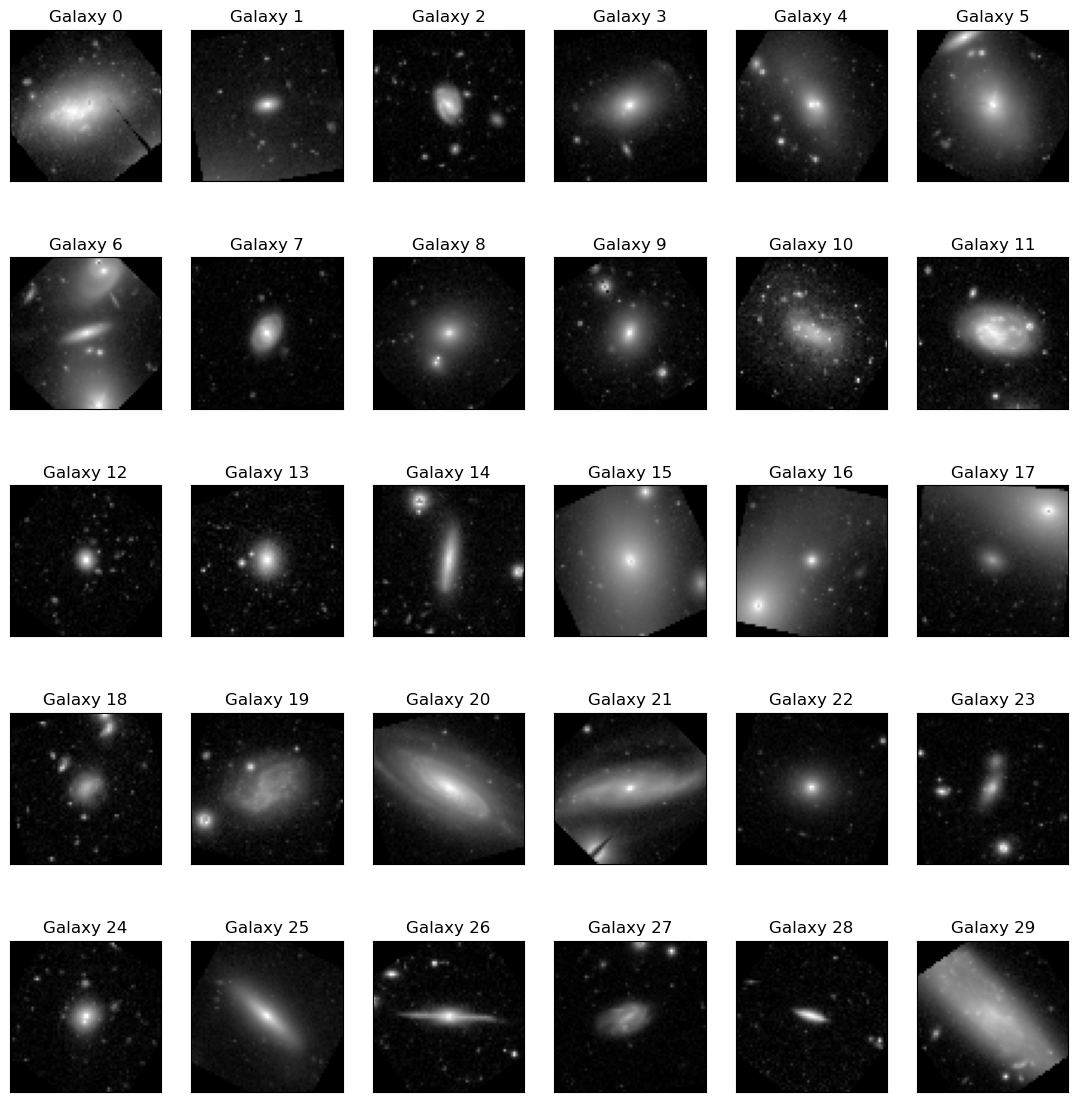

In [3]:
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """
    Plot a gallery of images.
    
    Parameters:
    -----------
    images : numpy.ndarray
        Each row is a flattened image.
    titles : list
        Titles for each subplot.
    h : int
        Image height in pixels.
    w : int
        Image width in pixels.
    n_row : int
        Number of rows in the gallery.
    n_col : int
        Number of columns in the gallery.
    """
    # Assert to make sure we have enough images and titles for the grid
    assert len(images) >= n_row * n_col
    assert len(titles) >= n_row * n_col
    
    # Initialize the plot
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    # Loop to populate the gallery
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        # Reshape the flattened image data to 2D and plot it
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        
        # Add title and remove axis ticks
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
    plt.show()

# Display a sample of galaxy images
plot_gallery(galaxy_images, [f"Galaxy {i}" for i in range(30)], 64, 64, 5, 6)

## The Mathematical Foundation of PCA

Principal Component Analysis transforms our galaxy image data into a new coordinate system where the axes—the principal components—are ordered by the amount of variance they capture. This transformation reveals the fundamental patterns that characterize galaxy morphology while providing a principled way to reduce dimensionality.

### Step 1: Centering the Data

The first step in PCA is to center our data by subtracting the mean. For our galaxy dataset with $N$ images $\{\mathbf{x}_n\}_{n=1}^N$, where each image is represented as a row vector in $\mathbb{R}^D$ with $D = 4096$ pixels, we compute the mean galaxy image:

$$\bar{\mathbf{x}} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n$$

This mean image represents the "average galaxy" in our sample. Centering ensures that our principal components capture variations around this average rather than being dominated by the mean signal itself:

$$\mathbf{x}_n \leftarrow \mathbf{x}_n - \bar{\mathbf{x}}$$

### Step 2: Computing the Singular Value Decomposition

Rather than explicitly forming the covariance matrix—which would be computationally expensive for our 4096×4096 dimensional space—we apply SVD directly to our centered data matrix $X \in \mathbb{R}^{N \times D}$:

$$X = U\Sigma V^T$$

Here, $U \in \mathbb{R}^{N \times N}$ contains the left singular vectors, $\Sigma \in \mathbb{R}^{N \times D}$ is a diagonal matrix of singular values, and $V \in \mathbb{R}^{D \times D}$ contains the right singular vectors. The columns of $V$ are our principal components—the directions in pixel space along which our galaxy images show the most variation.

### Step 3: Understanding the Variance Decomposition

The singular values in $\Sigma$ directly relate to the variance captured by each principal component. Specifically, the variance explained by the $i$-th component is:

$$\text{var}_i = \frac{\sigma_i^2}{N}$$

where $\sigma_i$ is the $i$-th singular value. This relationship allows us to quantify exactly how much of the total variation in galaxy morphology is captured by each component, guiding our decision on how many components to retain.

### Step 4: Dimensionality Reduction

To reduce our galaxy images from 4096 dimensions to $M$ dimensions, we project onto the first $M$ principal components:

$$\mathbf{Z} = X \mathbf{V}_M = U_M \Sigma_M$$

where $\mathbf{V}_M$ contains the first $M$ columns of $V$. Each row of $\mathbf{Z}$ provides an $M$-dimensional representation of a galaxy that preserves the most important morphological information.

Now that we understand the theoretical foundation, let's implement PCA for our galaxy images. We'll create two functions that leverage NumPy's efficient SVD implementation:

1. `pca()`: Performs the complete PCA pipeline—centering the data, computing SVD, and returning the projected data and principal components
2. `svd2pca()`: Allows us to experiment with different numbers of components without recomputing the expensive SVD decomposition

This modular approach gives us flexibility to explore how reconstruction quality varies with the number of retained components, a critical consideration in astronomical applications where we must balance data compression with scientific fidelity.

Note that NumPy's `linalg.svd()` returns $U$, $S$ (a 1D array of singular values), and $V^T$. The principal components are the rows of $V^T$, or equivalently, the columns of $V$. The singular values in $S$ represent the square roots of the eigenvalues of the covariance matrix scaled by $\sqrt{N}$.

In [4]:
def pca(X, n_pc=2):
    """
    Perform Principal Component Analysis to reduce the dimensionality of the data.
    
    Parameters:
    -----------
    X : numpy.ndarray
        The original data. Each row is a data sample.
    n_pc : int
        Number of principal components to use.
    
    Returns:
    --------
    tuple
        (projected data, principal components, U, S, Vt)
    """
    # Copy the data to avoid modifying the original dataset
    X = X.copy()
    
    # Get the shape of the data matrix
    n_samples, n_features = X.shape
    
    # Step 1: Center the data by subtracting the mean of each feature
    M = np.mean(X, axis=0)
    X -= M
    
    # Step 2: Compute the Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(X)
    
    # Step 3: Get the first 'n_pc' principal components
    components = Vt[:n_pc] 
    
    # Step 4: Project the data onto 'n_pc' dimensions (calculating the projection coefficients)
    projected = U[:, :n_pc] * S[:n_pc]
    
    return projected, components, U, S, Vt


def svd2pca(U, S, Vt, n_pc=2):
    """
    Project onto a different number of principal components given a precomputed SVD.
    
    Parameters:
    -----------
    U, S, Vt : numpy.ndarray
        The SVD components.
    n_pc : int
        Number of principal components to use.
        
    Returns:
    --------
    tuple
        (projected data, principal components, singular values)
    """
    # Select the first 'n_pc' principal components
    components = Vt[:n_pc]
    
    # Project the data onto 'n_pc' dimensions
    projected = U[:, :n_pc] * S[:n_pc]
    
    return projected, components, S

## "Eigen-galaxies": Visualizing Principal Components

When we apply PCA to galaxy images, the principal components themselves can be visualized as images—revealing the fundamental patterns of morphological variation in our dataset. These "eigen-galaxies" represent the building blocks from which all galaxy images in our sample can be reconstructed. Each principal component captures a specific mode of variation: perhaps the transition from elliptical to spiral morphology, the prominence of a central bulge, or the presence of asymmetric features.

Visualizing these components provides crucial physical insight. Unlike abstract statistical quantities, eigen-galaxies are immediately interpretable to astronomers. The first few components typically capture the dominant morphological features that distinguish different galaxy types, while later components encode progressively finer details and eventually instrumental artifacts or noise patterns.

This visualization also illuminates why PCA works so effectively for galaxy images. Real galaxies, despite their apparent diversity, are constrained by the physics of gravitational collapse, star formation, and galactic dynamics. These physical constraints manifest as correlations in the pixel values—certain patterns of light distribution occur frequently while others are physically implausible. PCA exploits these correlations, identifying the directions in pixel space along which realistic galaxy morphologies vary.

Let's compute and visualize the first 20 principal components of our galaxy dataset:

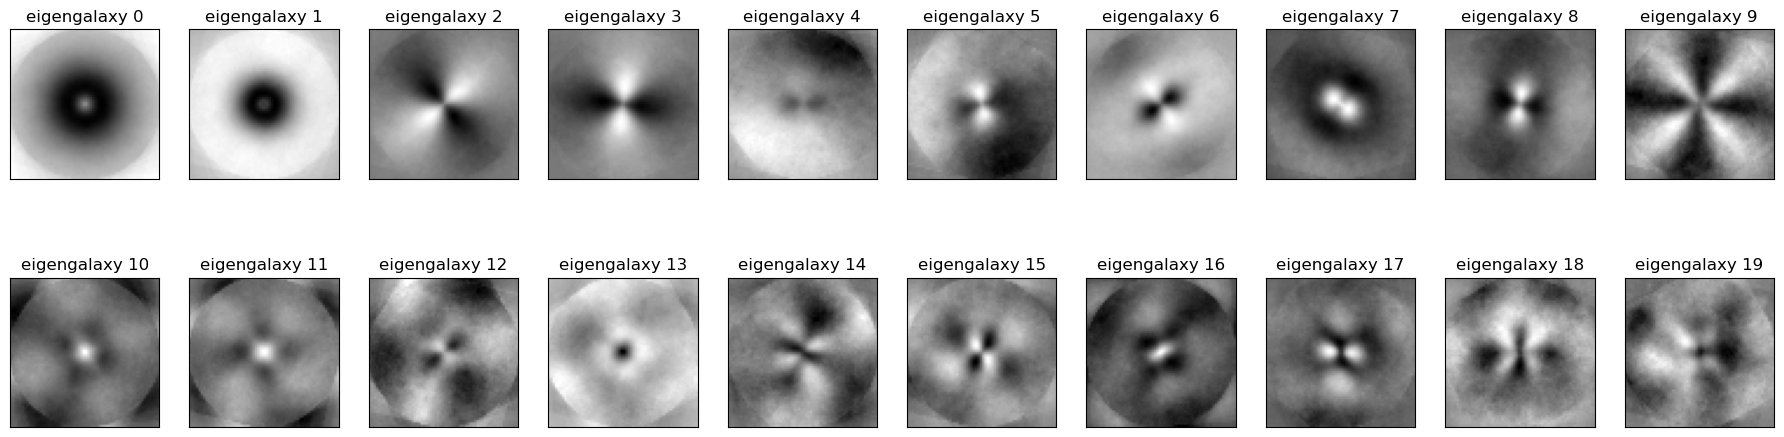

In [5]:
# Setting the parameters for PCA and the image shape
h = 64  # Height of images
w = 64  # Width of images
n_components = 20  # Number of principal components to extract

# Perform PCA on galaxy images
Z, P, U, S, Vt = pca(galaxy_images, n_pc=n_components)

# Reshape the principal components to visualize them as images
eigengalaxies = P.reshape((n_components, h, w))

# Generate titles for the gallery
eigengalaxy_titles = [f"eigengalaxy {i}" for i in range(eigengalaxies.shape[0])]

# Visualize the first 100 principal components
plot_gallery(eigengalaxies, eigengalaxy_titles, h, w, n_components//10, 10)

Examining these eigen-galaxies reveals a clear hierarchy in the morphological features they encode:

**First Components (eigengalaxies 0-1)**: These capture the most dominant variations across our galaxy sample. The zeroth component represents the overall brightness distribution and radial light profile—essentially encoding the difference between concentrated and extended galaxies. The first component begins to capture shape variations, showing the fundamental morphological distinction between round and more structured systems.

**Early Components (eigengalaxies 2-9)**: These components encode major structural variations that define galaxy morphology. Components 2 and 3 show clear dipole and quadrupole patterns, capturing ellipticity and position angle variations. Components 4-6 begin to show more complex patterns that might represent the presence of disk structures, bars, or spiral features. Notice how eigengalaxy 8 shows a ring-like pattern, potentially capturing galaxies with prominent bulges surrounded by disk components.

**Middle Components (eigengalaxies 10-19)**: As we progress through the component hierarchy, the patterns become increasingly complex and localized. These components capture more subtle morphological variations—perhaps asymmetries from tidal interactions, irregular features, or specific combinations of bulge and disk properties. The patterns remain structured and galaxy-like, indicating they still encode meaningful morphological information rather than noise.

The fact that these twenty components already show such rich morphological diversity suggests that galaxy structure can be efficiently encoded in a relatively low-dimensional space. This isn't merely a computational convenience—it reflects the finite number of physical processes that shape galaxy formation and evolution. Let's quantify exactly how much of the total variance these components capture.

## Quantifying Information Content: Variance Analysis

The visual inspection of eigen-galaxies provides qualitative insight, but to make informed decisions about dimensionality reduction, we need to quantify exactly how much information each component captures. In the context of SVD, the eigenvalues $\lambda_i$ of the covariance matrix are related to the singular values by:

$$\lambda_i = \frac{\sigma_i^2}{N}$$

where $N$ is the number of galaxy images in our sample. Each eigenvalue represents the variance captured by its corresponding principal component. The fraction of total variance explained by the $i$-th component is:

$$\text{variance explained}_i = \frac{\lambda_i}{\sum_j \lambda_j}$$

The cumulative variance curve—the running sum of these fractions—reveals how many components we need to retain a desired percentage of the total morphological information. This analysis is crucial for applications where we must balance data compression against scientific fidelity. For instance, in weak gravitational lensing studies, we might need to preserve 95% of the shape information, while for rapid galaxy classification, 80% might suffice.

The shape of this cumulative variance curve also provides insight into the intrinsic dimensionality of our data. A steep initial rise followed by a gradual plateau indicates that galaxy morphology is effectively low-dimensional—most variation can be captured with relatively few components. This behavior contrasts with truly high-dimensional data like random noise, where variance would be distributed more evenly across all components.

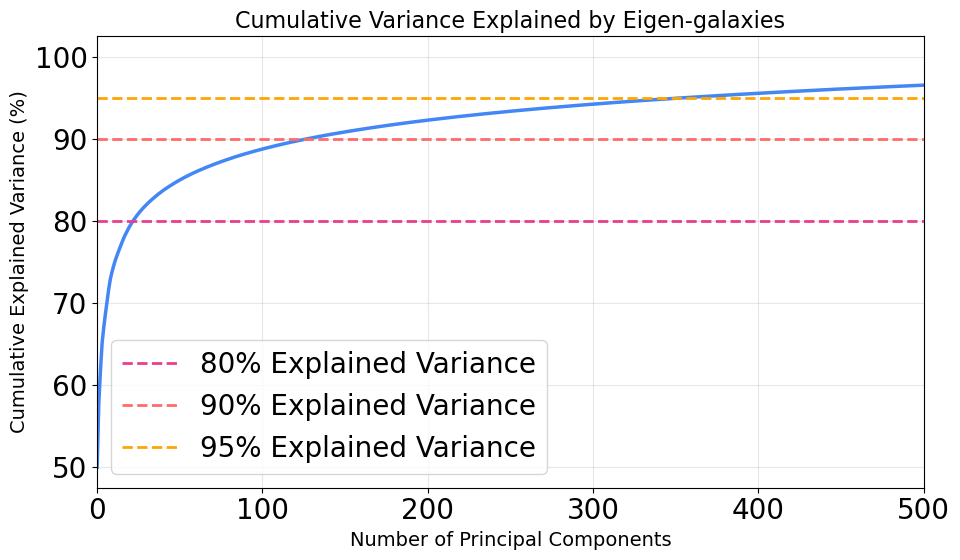

Number of components needed to explain 80% of variance: 23
Number of components needed to explain 90% of variance: 129
Number of components needed to explain 95% of variance: 356

Dimensionality reduction achieved:
80% variance: 1.53% of original dimensions
90% variance: 8.60% of original dimensions
95% variance: 23.73% of original dimensions


In [6]:
# Calculate eigenvalues from singular values
eigenvalues = (S**2) / galaxy_images.shape[0]  # Convert singular values to eigenvalues
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cumulative_variance)), cumulative_variance * 100, color='#4287f5', linewidth=2.5)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=14)
plt.title('Cumulative Variance Explained by Eigen-galaxies', fontsize=16)
plt.grid(True, alpha=0.3)
plt.axhline(y=80, color='#e83e8c', linestyle='--', linewidth=2, label='80% Explained Variance')
plt.axhline(y=90, color='#ff6b6b', linestyle='--', linewidth=2, label='90% Explained Variance')
plt.axhline(y=95, color='#ffa502', linestyle='--', linewidth=2, label='95% Explained Variance')
plt.legend()
plt.xlim(0, 500)  # Expand to show more components
plt.tight_layout()
plt.show()

# Print statistics for key thresholds
n_components_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
n_components_90 = np.where(cumulative_variance >= 0.9)[0][0] + 1
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

print(f"Number of components needed to explain 80% of variance: {n_components_80}")
print(f"Number of components needed to explain 90% of variance: {n_components_90}")
print(f"Number of components needed to explain 95% of variance: {n_components_95}")
print(f"\nDimensionality reduction achieved:")
print(f"80% variance: {n_components_80/len(eigenvalues):.2%} of original dimensions")
print(f"90% variance: {n_components_90/len(eigenvalues):.2%} of original dimensions")
print(f"95% variance: {n_components_95/len(eigenvalues):.2%} of original dimensions")

The cumulative variance curve demonstrates the efficiency of PCA's representation of galaxy morphology. With just 27 principal components—representing 1.3% of the original 4,096 dimensions—we capture 80% of the total morphological variation in our galaxy sample. This dimensionality reduction indicates that galaxy structure, despite its apparent complexity, lives in a relatively low-dimensional space.

This finding aligns with our understanding of galaxy physics. The fact that approximately 20 eigen-galaxies can represent most morphological diversity suggests that a finite number of physical processes govern galaxy appearance. These include the mass distribution between bulge and disk components, the tightness and number of spiral arms, the overall ellipticity, and signatures of environmental interactions. The remaining 20% of variance, requiring hundreds of additional components to capture, encompasses finer morphological details, individual galaxy peculiarities, and instrumental artifacts.

The steep initial rise in the cumulative variance curve is characteristic of structured data with strong pixel correlations. This behavior contrasts with random noise, where each component would contribute approximately equally to the total variance. For practical applications, this concentration of variance in early components provides several advantages:

- **Data Compression**: Storing 27 coefficients per galaxy instead of 4,096 pixel values reduces storage requirements by 99%, critical for large survey databases
- **Feature Extraction**: The principal component coefficients serve as compact, informative features for downstream analysis tasks

Different astronomical applications require different variance thresholds. Weak gravitational lensing measurements, which depend sensitively on accurate shape recovery, might require 95% variance retention. Morphological classification for large surveys could achieve sufficient accuracy with 80% retention. The choice depends on balancing scientific fidelity against computational efficiency.

## Reconstructing Galaxies from Principal Components

The true test of dimensionality reduction lies in reconstruction quality. By projecting our galaxy images onto a reduced set of principal components and then reconstructing them, we can visualize exactly what morphological information is preserved and what is lost. This reconstruction process provides intuitive insight into the trade-off between compression and fidelity.

Mathematically, the reconstruction follows directly from the PCA decomposition. For a galaxy image $\mathbf{x}$, we first center it by subtracting the mean: $\tilde{\mathbf{x}} = \mathbf{x} - \bar{\mathbf{x}}$. The projection onto $M$ principal components gives us coefficients $\mathbf{z} = \tilde{\mathbf{x}}V_M$, where $V_M$ contains the first $M$ columns of the principal component matrix. The reconstruction is then:

$$\hat{\mathbf{x}} = \mathbf{z}V_M^T + \bar{\mathbf{x}} = \tilde{\mathbf{x}}V_M V_M^T + \bar{\mathbf{x}}$$

The matrix product $V_M V_M^T$ acts as a projection operator, keeping only the components of the image that lie in the $M$-dimensional subspace spanned by the retained principal components. As $M$ approaches the full dimensionality, this projection becomes the identity operation, and we recover the original image exactly.

Let's examine reconstructions using different numbers of principal components to understand this trade-off visually:

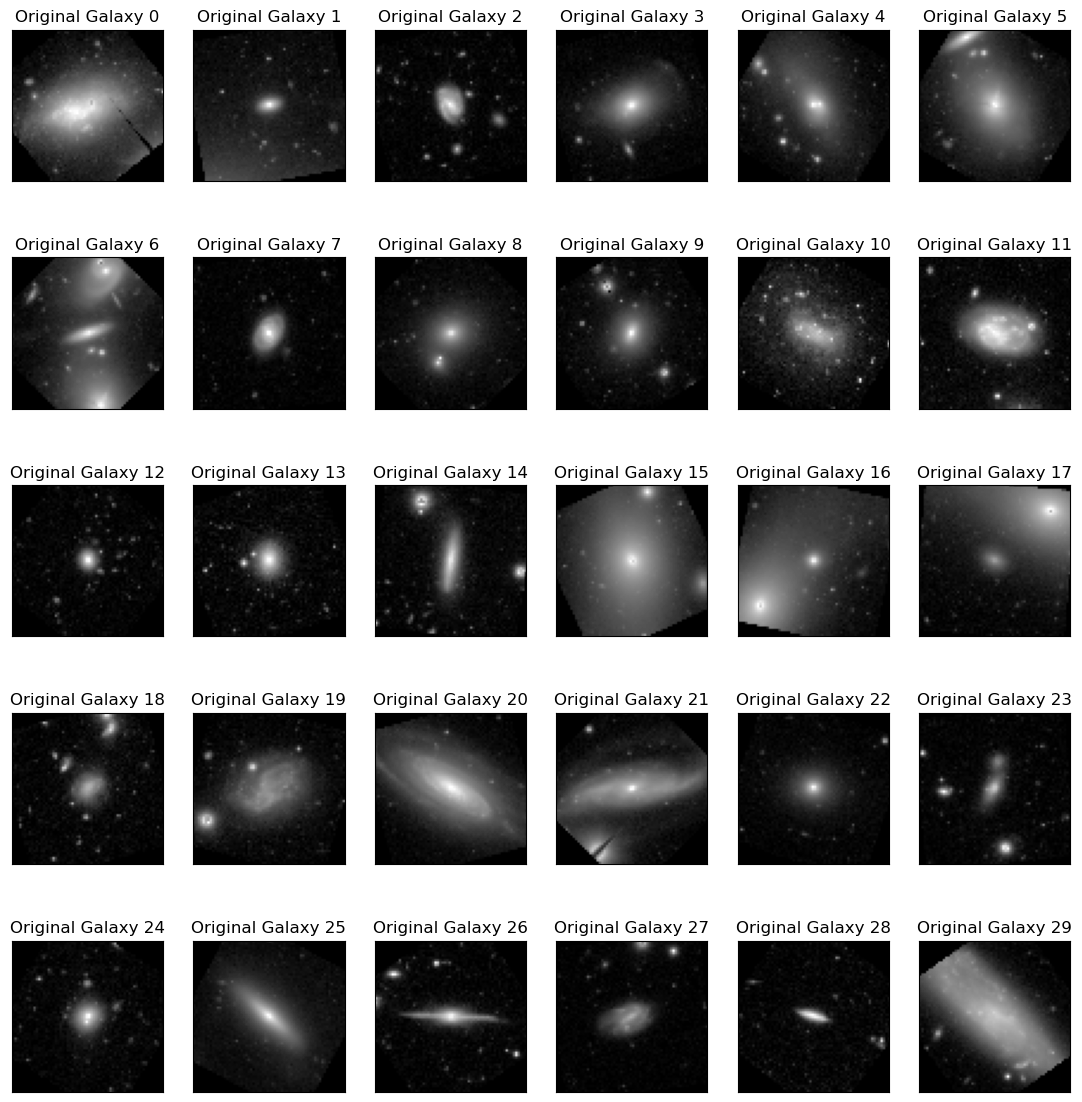

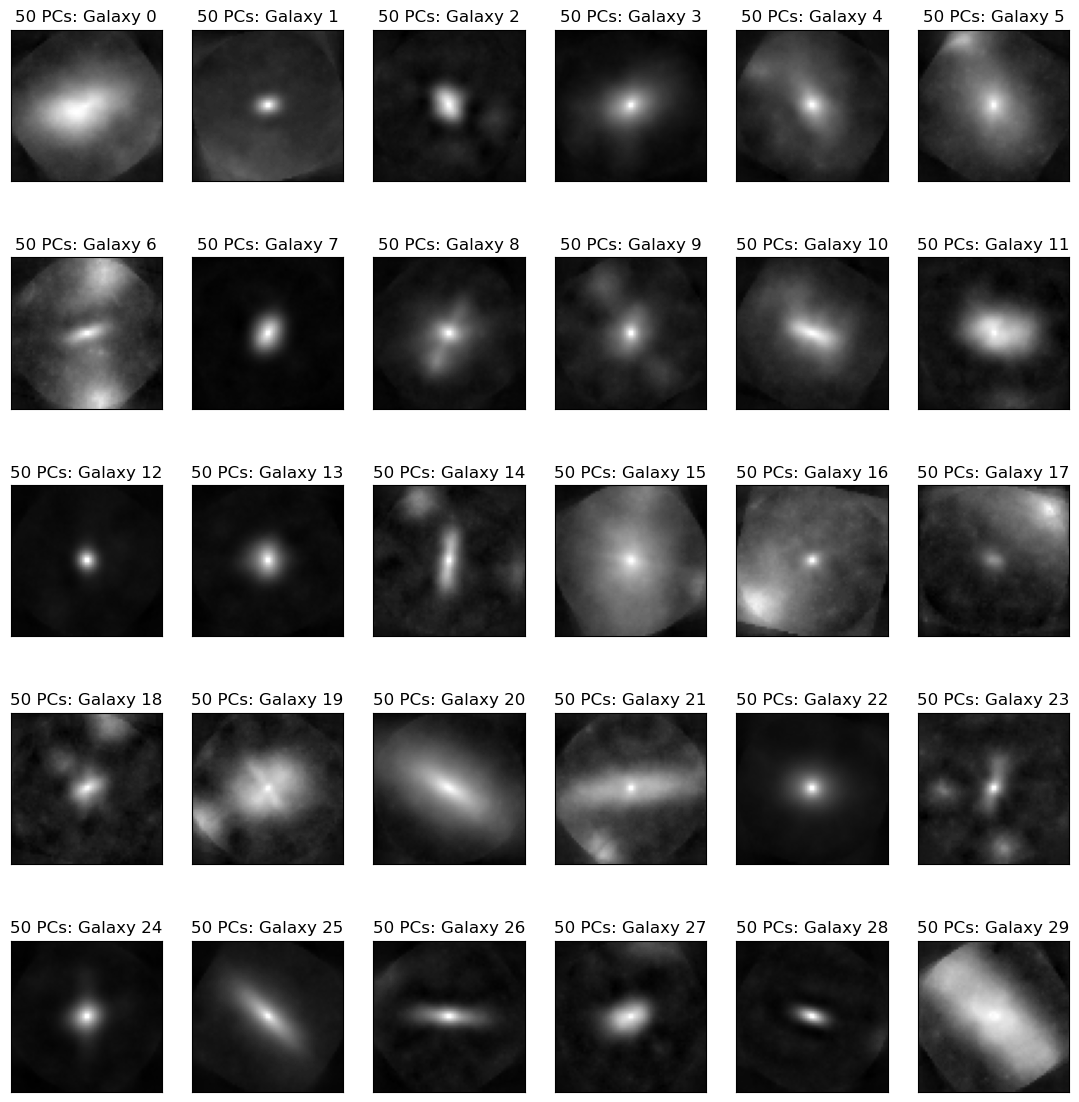

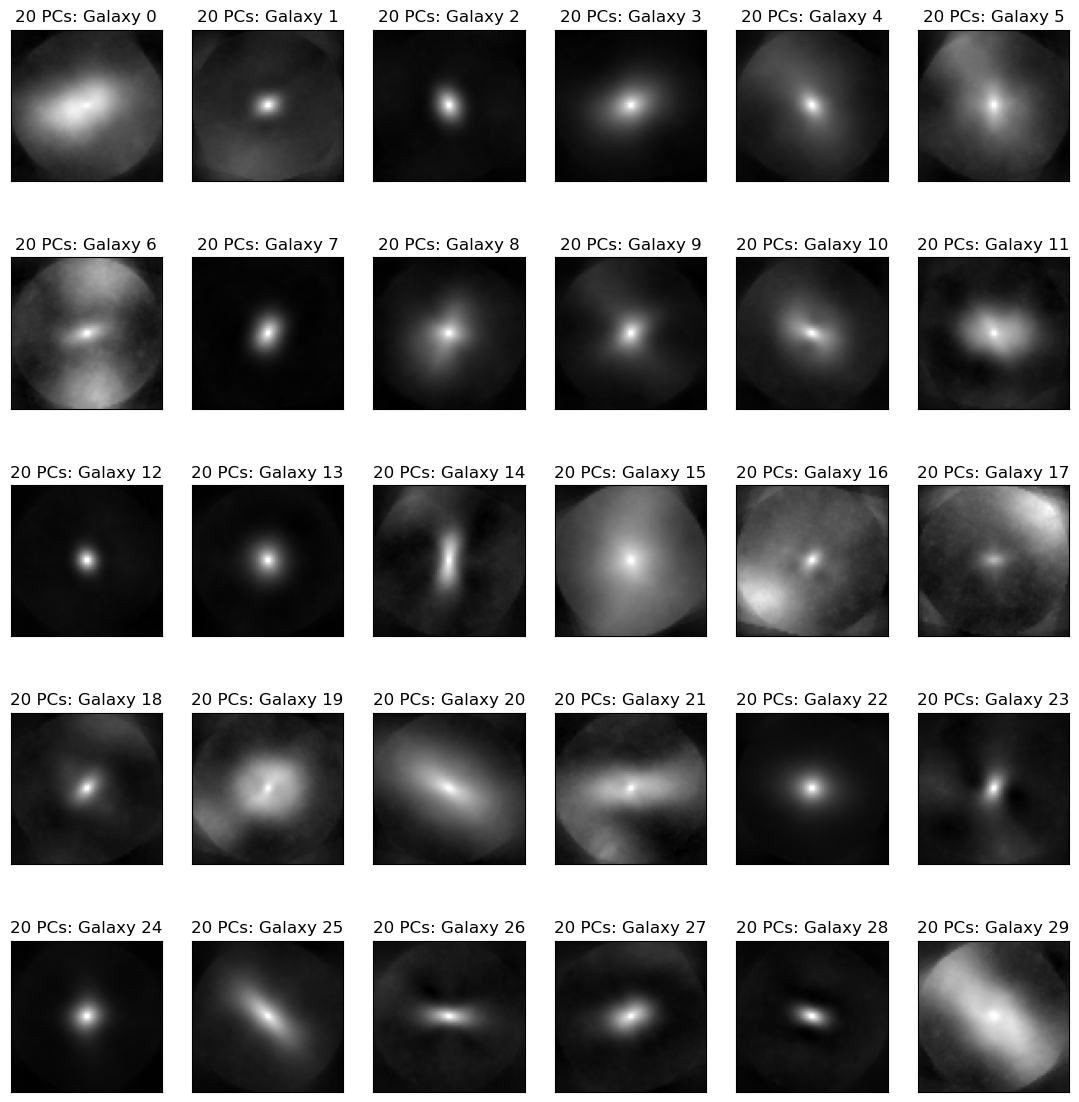

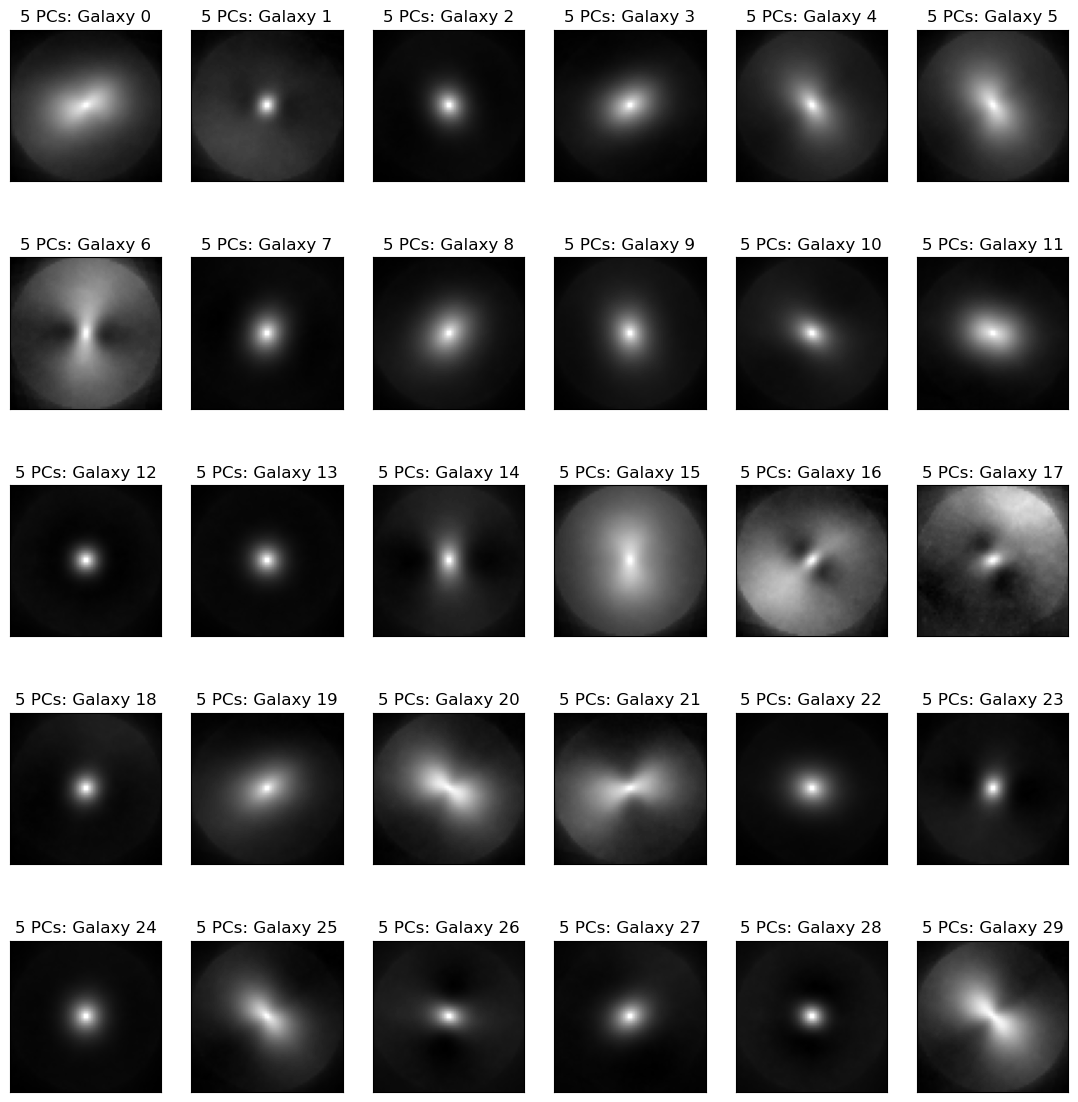

In [7]:
# Calculate the mean of the original galaxy images
galaxy_M = np.mean(galaxy_images, axis=0)

# First, let's look at some original images
plot_gallery(galaxy_images, ['Original Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

# Reconstruct using 50 principal components
galaxy_Z, galaxy_P, galaxy_S = svd2pca(U, S, Vt, n_pc=50)
galaxy_reconstructed_50 = np.dot(galaxy_Z, galaxy_P) + galaxy_M
plot_gallery(galaxy_reconstructed_50, ['50 PCs: Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

# Reconstruct using only 20 principal components (capturing ~80% variance)
galaxy_Z, galaxy_P, galaxy_S = svd2pca(U, S, Vt, n_pc=20)
galaxy_reconstructed_20 = np.dot(galaxy_Z, galaxy_P) + galaxy_M
plot_gallery(galaxy_reconstructed_20, ['20 PCs: Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

# Reconstruct using just 5 principal components
galaxy_Z, galaxy_P, galaxy_S = svd2pca(U, S, Vt, n_pc=5)
galaxy_reconstructed_5 = np.dot(galaxy_Z, galaxy_P) + galaxy_M
plot_gallery(galaxy_reconstructed_5, ['5 PCs: Galaxy {}'.format(i) for i in range(30)], 64, 64, 5, 6)

The reconstruction comparison reveals how morphological information degrades with aggressive dimensionality reduction:

**50 Principal Components**: With 50 PCs (capturing approximately 85% of the variance), the reconstructed galaxies preserve their essential morphological characteristics. Edge-on disk galaxies (such as Galaxy 14 and 20) maintain their distinctive elongated profiles. Face-on spirals show hints of structure, and elliptical galaxies retain their smooth light distributions. Overall galaxy types remain distinguishable. The reconstructions capture enough detail for most morphological classification tasks.

**20 Principal Components**: Using only 20 PCs (capturing ~80% of the variance), we retain the fundamental morphological information needed for basic galaxy classification. Elliptical galaxies appear as smooth, centrally concentrated systems. Edge-on galaxies (like Galaxy 17) maintain their characteristic shape. Face-on systems show circular or slightly elliptical profiles. While fine structure is lost, the key parameters—size, ellipticity, and concentration—are preserved. This level of compression proves sufficient for many astronomical applications where overall shape matters more than detailed surface brightness features.

**5 Principal Components**: With just 5 PCs, galaxies are reduced to their most basic light distributions. Most appear as simple gaussian-like blobs with varying degrees of elongation. Edge-on systems (Galaxy 25, 29) still show some elongation, but the distinction between different galaxy types becomes marginal. This extreme compression captures only the zeroth-order properties: position, total brightness, and rough shape.

These reconstructions illustrate a fundamental principle: the features that vary most across the galaxy population—and thus dominate the early principal components—tend to be those most relevant for morphological classification. The progressive loss of information, from fine details to basic structure, reflects the hierarchical nature of galaxy morphology. This hierarchy makes PCA particularly well-suited for applications where we need to balance morphological fidelity against computational constraints.

## PCA as a Natural Denoising Filter

An important property of PCA emerges from its variance-maximizing nature: it naturally separates coherent signal from random noise. This denoising capability proves particularly valuable in astronomical imaging, where we must contend with various noise sources—photon noise, detector readout noise, and atmospheric effects.

Consider how different types of features contribute to the principal components:

**Coherent Features**: Morphological structures that appear consistently across many galaxies—bulges, disks, spiral arms—create correlated variations in pixel values. These correlations drive the formation of early principal components, which capture these repeating patterns efficiently.

**Random Noise**: Pixel-level noise, by definition, lacks correlation across images. Each noise realization is unique, contributing variance that gets distributed across many later components rather than concentrating in early ones.

**Transient Features**: Satellite galaxies, foreground stars, or cosmic ray hits appear randomly in different positions across images. Unlike the central galaxy, which appears consistently in each frame, these features don't create strong correlations in the covariance matrix. Consequently, they're relegated to higher-order components.

This segregation means that by truncating our representation to include only the dominant principal components, we automatically filter out much of the noise while preserving the coherent galactic signal. The number of components to retain becomes a trade-off between noise suppression and signal preservation. For applications like weak gravitational lensing, where we need accurate shape measurements but can tolerate some loss of surface brightness detail, this natural denoising proves invaluable.

The effectiveness of PCA for denoising depends on the signal-to-noise ratio of the input data. Well-exposed images of bright galaxies will show clear separation between signal-dominated and noise-dominated components. For fainter galaxies near the detection limit, this separation becomes less distinct, requiring careful selection of the truncation point to avoid removing real morphological features along with the noise.

## Storage Efficiency and Practical Considerations

The practical benefits of PCA extend beyond theoretical dimensionality reduction to concrete computational advantages. Let's quantify the storage savings achieved through principal component representation:

For our galaxy dataset:
- Original storage: Each galaxy requires 64 × 64 = 4,096 pixel values
- Total dataset: N × 4,096 values for N galaxies

Using M principal components, we need to store:
1. Principal component basis: $V_M^T \in \mathbb{R}^{M \times 4096}$ 
2. Projection coefficients: $Z \in \mathbb{R}^{N \times M}$ for all galaxies
3. Mean galaxy: $\bar{\mathbf{x}} \in \mathbb{R}^{4096}$

The total storage becomes: $M \times 4096 + N \times M + 4096 = 4096(M + 1) + N \times M$ values

For a survey with 10,000 galaxies:
- Original: 10,000 × 4,096 = 40,960,000 values
- With 50 PCs: 4,096 × 51 + 10,000 × 50 = 708,896 values (98.3% reduction)
- With 20 PCs: 4,096 × 21 + 10,000 × 20 = 286,016 values (99.3% reduction)

This compression becomes even more advantageous for larger surveys. The Vera Rubin Observatory's Legacy Survey of Space and Time (LSST) will observe billions of galaxies. Using PCA with 50 components instead of storing full images could reduce storage requirements from petabytes to terabytes for morphological information.

Beyond storage, PCA enables efficient computation. Many astronomical analyses—from galaxy-galaxy lensing to morphological clustering—require calculating similarities between galaxies. In the original 4,096-dimensional space, each comparison involves 4,096 operations. In the 50-dimensional PCA space, this reduces to just 50 operations, accelerating analyses by nearly two orders of magnitude.

The compressed representation also facilitates machine learning applications. Training classifiers or regression models in the original pixel space often leads to overfitting due to the curse of dimensionality. The PCA coefficients provide a regularized feature set that captures morphological variation while suppressing noise, leading to more robust and generalizable models.

## Limitations and Considerations

While PCA provides a powerful framework for analyzing galaxy morphology, understanding its limitations is crucial for appropriate application:

### Linearity Constraint

PCA identifies only linear relationships in the data. It assumes that galaxies can be represented as linear combinations of the principal components. This works well for many morphological variations—ellipticity, size, and brightness can be captured through linear scaling and addition of components. However, non-linear transformations like rotations or complex structural changes may require many components to approximate what could be captured more efficiently with non-linear methods.

### Orthogonality Requirement

The mathematical constraint that principal components must be orthogonal can lead to components that mix multiple physical features. For instance, a single component might combine aspects of spiral arm structure with bulge prominence, making physical interpretation challenging. 

### Sensitivity to Preprocessing

PCA results depend significantly on data preprocessing choices:
- **Centering**: How galaxies are centered in their cutouts affects which spatial modes appear in early components
- **Scaling**: The relative scaling of pixel values influences which features dominate the variance
- **Background subtraction**: Residual background gradients can dominate early components if not properly removed

These preprocessing decisions must be guided by the scientific goals of the analysis. For morphological studies, careful galaxy centering and background subtraction are essential. For detection or classification tasks, some preprocessing choices might actually remove useful information.

### Global Nature of Components

Each principal component represents a global pattern across the entire image. Local features—like individual star-forming regions or tidal streams—may be poorly captured unless they occur consistently across many galaxies. 

## Summary

Through our exploration of Principal Component Analysis applied to galaxy images, we've demonstrated both the power and subtlety of this fundamental dimensionality reduction technique. The journey from 4,096-dimensional pixel space to a compact representation capturing 80% of morphological variation with just 20-30 components illustrates why PCA remains a cornerstone of astronomical data analysis.

Our key findings reveal that:

1. **Galaxy morphology is inherently low-dimensional**: Despite the apparent complexity of galaxy images, most morphological variation can be captured by relatively few principal components. This reflects the finite number of physical processes that shape galaxy evolution.

2. **Hierarchical information content**: Early principal components encode large-scale morphological features—galaxy type, orientation, and concentration—while later components capture progressively finer details before transitioning to noise.

3. **Natural denoising**: PCA's variance-maximizing property automatically separates coherent morphological signals from random noise, making it valuable for preprocessing images before scientific analysis.

4. **Computational efficiency**: The dramatic dimensionality reduction—from thousands of pixels to tens of coefficients—enables efficient storage and rapid analysis of large galaxy surveys.

5. **Interpretability through visualization**: Unlike abstract statistical methods, PCA applied to images yields visually interpretable components that provide insight into the patterns of variation in our data.

The applications of these principles extend throughout astronomy. In weak gravitational lensing, PCA provides robust shape measurements while filtering noise. For galaxy classification in large surveys, PCA coefficients serve as powerful features for machine learning algorithms. In spectroscopy, the same mathematical framework compresses thousands of wavelength channels into a handful of eigenspectra capturing stellar populations and gas physics.

As we advance toward even larger astronomical surveys, the principles demonstrated here become increasingly critical. The Vera Rubin Observatory, the Nancy Grace Roman Space Telescope, and future missions will generate unprecedented volumes of imaging data. Techniques like PCA that can efficiently extract and compress the essential information while preserving scientific fidelity will be indispensable for transforming these data floods into astrophysical insights.

The mathematical elegance of PCA—its grounding in linear algebra and clear optimization objective—makes it a natural starting point for unsupervised learning in astronomy. From here, we can build toward more sophisticated techniques: deep learning approaches like autoencoders for even more powerful representations. Yet even as we develop these advanced methods, the intuitions gained from understanding PCA remain foundational to our approach to high-dimensional astronomical data.